Epoch 1/50
500/500 [==============================] - 568s 1s/step - loss: 1.5480 - accuracy: 0.5007 - val_loss: 110.6170 - val_accuracy: 0.0980
Epoch 2/50
500/500 [==============================] - 576s 1s/step - loss: 0.4911 - accuracy: 0.8316 - val_loss: 51.2270 - val_accuracy: 0.1042
Epoch 3/50
500/500 [==============================] - 571s 1s/step - loss: 0.2896 - accuracy: 0.9034 - val_loss: 274.9936 - val_accuracy: 0.0915
Epoch 4/50
500/500 [==============================] - 554s 1s/step - loss: 0.2409 - accuracy: 0.9195 - val_loss: 107.4322 - val_accuracy: 0.0915
Epoch 5/50
500/500 [==============================] - 562s 1s/step - loss: 0.1624 - accuracy: 0.9469 - val_loss: 47.0768 - val_accuracy: 0.0948
Epoch 6/50
500/500 [==============================] - 558s 1s/step - loss: 0.1385 - accuracy: 0.9538 - val_loss: 313.8902 - val_accuracy: 0.0915
Epoch 7/50
500/500 [==============================] - 570s 1s/step - loss: 0.1220 - accuracy: 0.9591 - val_loss: 47.8663 - val_accur

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

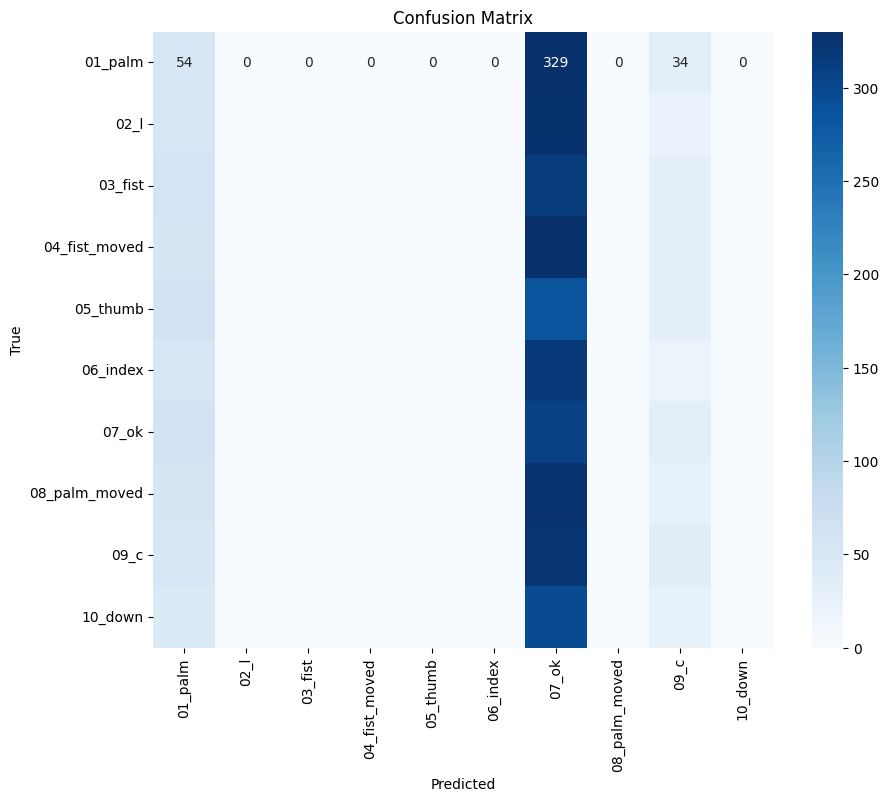

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def LoadData(Path, img_height, img_width):
    Images = []
    Labels = []
    for subject_folder in os.listdir(Path):
        subject_path = os.path.join(Path, subject_folder)
        if os.path.isdir(subject_path):
            for gesture_folder in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture_folder)
                if os.path.isdir(gesture_path):
                    for image_name in os.listdir(gesture_path):
                        image_path = os.path.join(gesture_path, image_name)
                        image = plt.imread(image_path)
                        if image is not None:
                            image = cv2.resize(image, (img_height, img_width))
                            if len(image.shape) == 2:  # Handle grayscale images
                                image = np.stack((image,) * 3, axis=-1)
                            Images.append(image)
                            Labels.append(gesture_folder)
    return np.array(Images), np.array(Labels)

# Set image dimensions
ImgHeight, ImgWidth = 128, 128

# Load the data
Images, Labels = LoadData('./leapGestRecog', ImgHeight, ImgWidth)
NumChannels = 3  # RGB images

# Encode labels
LabelEn = LabelEncoder()
EncodedLabels = LabelEn.fit_transform(Labels)

# Split the data into training and testing sets
XTrain, XTest, YTrain, YTest = train_test_split(Images, EncodedLabels, test_size=0.2, random_state=42)

# Normalize the images
XTrain = XTrain / 255.0
XTest = XTest / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare the data generators
train_generator = datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = ImageDataGenerator().flow(XTest, YTest, batch_size=32)

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(ImgHeight, ImgWidth, NumChannels)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(10, activation='softmax')  # Adjust based on the number of gestures
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('BModel.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model.load_weights('BModel.h5')

# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predictions and classification report
YPred = model.predict(test_generator)
YPredClass = np.argmax(YPred, axis=1)
print(classification_report(YTest, YPredClass, target_names=LabelEn.classes_))

# Confusion matrix
ConfMatrix = confusion_matrix(YTest, YPredClass)
plt.figure(figsize=(10, 8))
sns.heatmap(ConfMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEn.classes_, yticklabels=LabelEn.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()